## Dataset #1: Credit Card Risk

In [ ]:
pip install git+https://github.com/gavin-s-smith/mcrforest

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mcr(df_in):
    df_in = df_in.copy()
    df_in.columns = [ x.replace('MCR+', 'MCR- (lollypops) | MCR+ (bars)') for x in df_in.columns]
    ax = sns.barplot(x='MCR- (lollypops) | MCR+ (bars)',y='variable',data=df_in)

    plt.hlines(y=range(df_in.shape[0]), xmin=0, xmax=df_in['MCR-'], color='skyblue')
    plt.plot(df_in['MCR-'], range(df_in.shape[0]), "o", color = 'skyblue')

In [11]:
import pandas as pd
import mcrforest
df = pd.read_csv("clean_dataset.csv")

In [13]:
from sklearn import  datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#-- Define you training input and output
y = df["Approved"]
X = df.loc[:, ~df.columns.isin(['Approved','Industry','ZipCode'])]
cleanup = {"Ethnicity": {"Other": 4, "Latino": 3, "Asian": 2, "White": 1, "Black": 0}, "Citizen": {"ByBirth": 0, "ByOtherMeans": 1, "Temporary": 2}}
X.replace(cleanup, inplace = True)                               
# Split off a held-out test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42, shuffle = True)

In [17]:
%%time
from sklearn.model_selection import KFold, GridSearchCV
from mcrforest.forest import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mcrforest.forest import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from mcrforest.Datasets import get_demo_dataset

redo_cv = False
if redo_cv:
    # For the model class RF
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    # For the model class RF
    search = {'n_estimators':[200, 100, 50],'min_impurity_decrease':[0.0001,0.001,0.01],'max_features':[1,'auto']}
    rf_cv_model = GridSearchCV(RandomForestClassifier(bootstrap=False, random_state = 13111985), search, cv = kf, refit = True, verbose = 10)
    rf_best_model = rf_cv_model.fit(X_train, y_train.values.flatten()).best_estimator_
    print(rf_best_model.get_params())
else:
    best_params = {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'max_leaf_nodes': None,
                   'max_samples': None, 'mcr_tree_equivilient_tol': 1e-05, 'min_impurity_decrease': 0.0001, 'min_impurity_split': None, 'min_samples_leaf': 1, 
                   'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'performance_equivilence': True,
                   'random_state': 13111985, 'spoof_as_sklearn': False, 'verbose': 0, 'warm_start': False}    
    rf_best_model = RandomForestClassifier(**best_params)
    rf_best_model.fit(X_train, y_train.values.flatten())

print('RF Reference Model ACC_train: {}'.format(accuracy_score(y_train, rf_best_model.predict(X_train))))
print('RF Reference Model ACC_test: {}'.format(accuracy_score(y_test, rf_best_model.predict(X_test))))
print('RF best model params: ',rf_best_model)

RF Reference Model ACC_train: 0.9927536231884058
RF Reference Model ACC_test: 0.8260869565217391
RF best model params:  RandomForestClassifier(max_features=1, min_impurity_decrease=0.0001,
                       n_estimators=200, random_state=13111985)
CPU times: user 2.32 s, sys: 3.99 ms, total: 2.33 s
Wall time: 2.33 s


In [18]:
%%time
import mcrforest
from tqdm import tqdm
variables = []
mcrp = []
mcrm = []
i = 0
for c in tqdm(X_train.columns):
    variables.append(c)
    mcr_p = rf_best_model.mcr( X_train.values,y_train.values.flatten(), np.asarray([i]), 
                        num_times = 100, debug = False, mcr_type = 1, mcr_as_ratio=False)

    mcr_m = rf_best_model.mcr( X_train.values,y_train.values.flatten(), np.asarray([i]), 
                        num_times = 100, debug = False, mcr_type = -1, mcr_as_ratio=False)

    mcrm.append(mcr_m)
    mcrp.append(mcr_p)
    i += 1

rf_results = pd.DataFrame({'variable':variables, 'MCR+':mcrp, 'MCR-':mcrm})

100%|██████████| 13/13 [02:40<00:00, 12.31s/it]

CPU times: user 2min 38s, sys: 1.77 s, total: 2min 40s
Wall time: 2min 40s


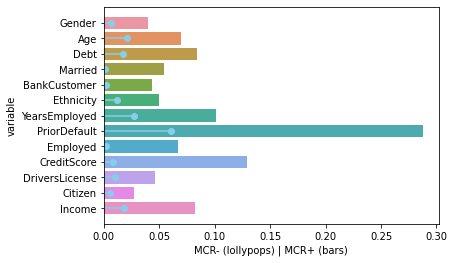

In [19]:
plot_mcr(rf_results)

Text(0.5, 0, 'Decrease in impurity score')

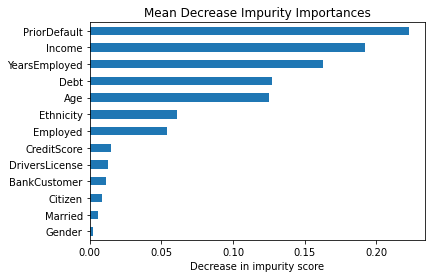

In [ ]:
feature_names = list(X.columns.values)

mdi_importances = pd.Series(
    rf_best_model[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
mdi_importances

ax = mdi_importances.plot.barh()
ax.set_title("Mean Decrease Impurity Importances")
ax.set_xlabel("Decrease in impurity score")



In [21]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_best_model, X_train, y_train, n_repeats=50, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

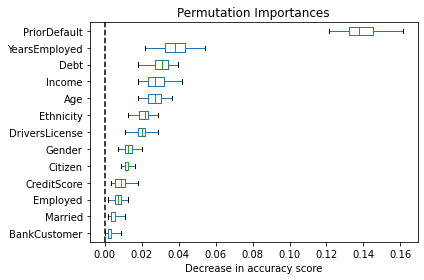

In [ ]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()